# Cross-species modality prediction using scEve

In [1]:
import scanpy as sc
import scparadise
import os
from scipy import sparse
from mousipy import translate
import muon as mu
import numpy as np
import pandas as pd
import warnings 

warnings.simplefilter('ignore')
sc.set_figure_params(dpi = 150, dpi_save = 600)

C:\Users\vadim\anaconda3\envs\scrna\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Recommendations about dataset 
Our models are trained using shifted logarithm normalized data. <br>
We recommend the shifted logarithm data normalization method for the proper use of our models. <br>
sc.pp.normalize_total(adata, target_sum=None) <br>
sc.pp.log1p(adata) <br>
adata.raw = adata

In [2]:
# Load ADT data from 10x Genomics
url = "https://cf.10xgenomics.com/samples/cell-exp/7.2.0/4plex_mouse_LymphNode_Spleen_TotalSeqC_multiplex_LymphNode1_BC1_AB1/4plex_mouse_LymphNode_Spleen_TotalSeqC_multiplex_LymphNode1_BC1_AB1_count_sample_filtered_feature_bc_matrix.h5"
mdata = mu.read_10x_h5("dataset.h5", backup_url = url)
mdata.var_names_make_unique()
# RNA data
adata = mdata.mod['rna'].copy()
# Protein data
adata_adt = mdata.mod['prot'].copy()
del mdata
print('RNA data', adata, sep='\n')
print('Protein data', adata_adt, sep='\n')

RNA data
AnnData object with n_obs × n_vars = 7579 × 19059
    var: 'gene_ids', 'feature_types', 'genome'
Protein data
AnnData object with n_obs × n_vars = 7579 × 122
    var: 'gene_ids', 'feature_types', 'genome'


## Gene expression data processing

In [3]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("mt-")

In [4]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, log1p=True
)

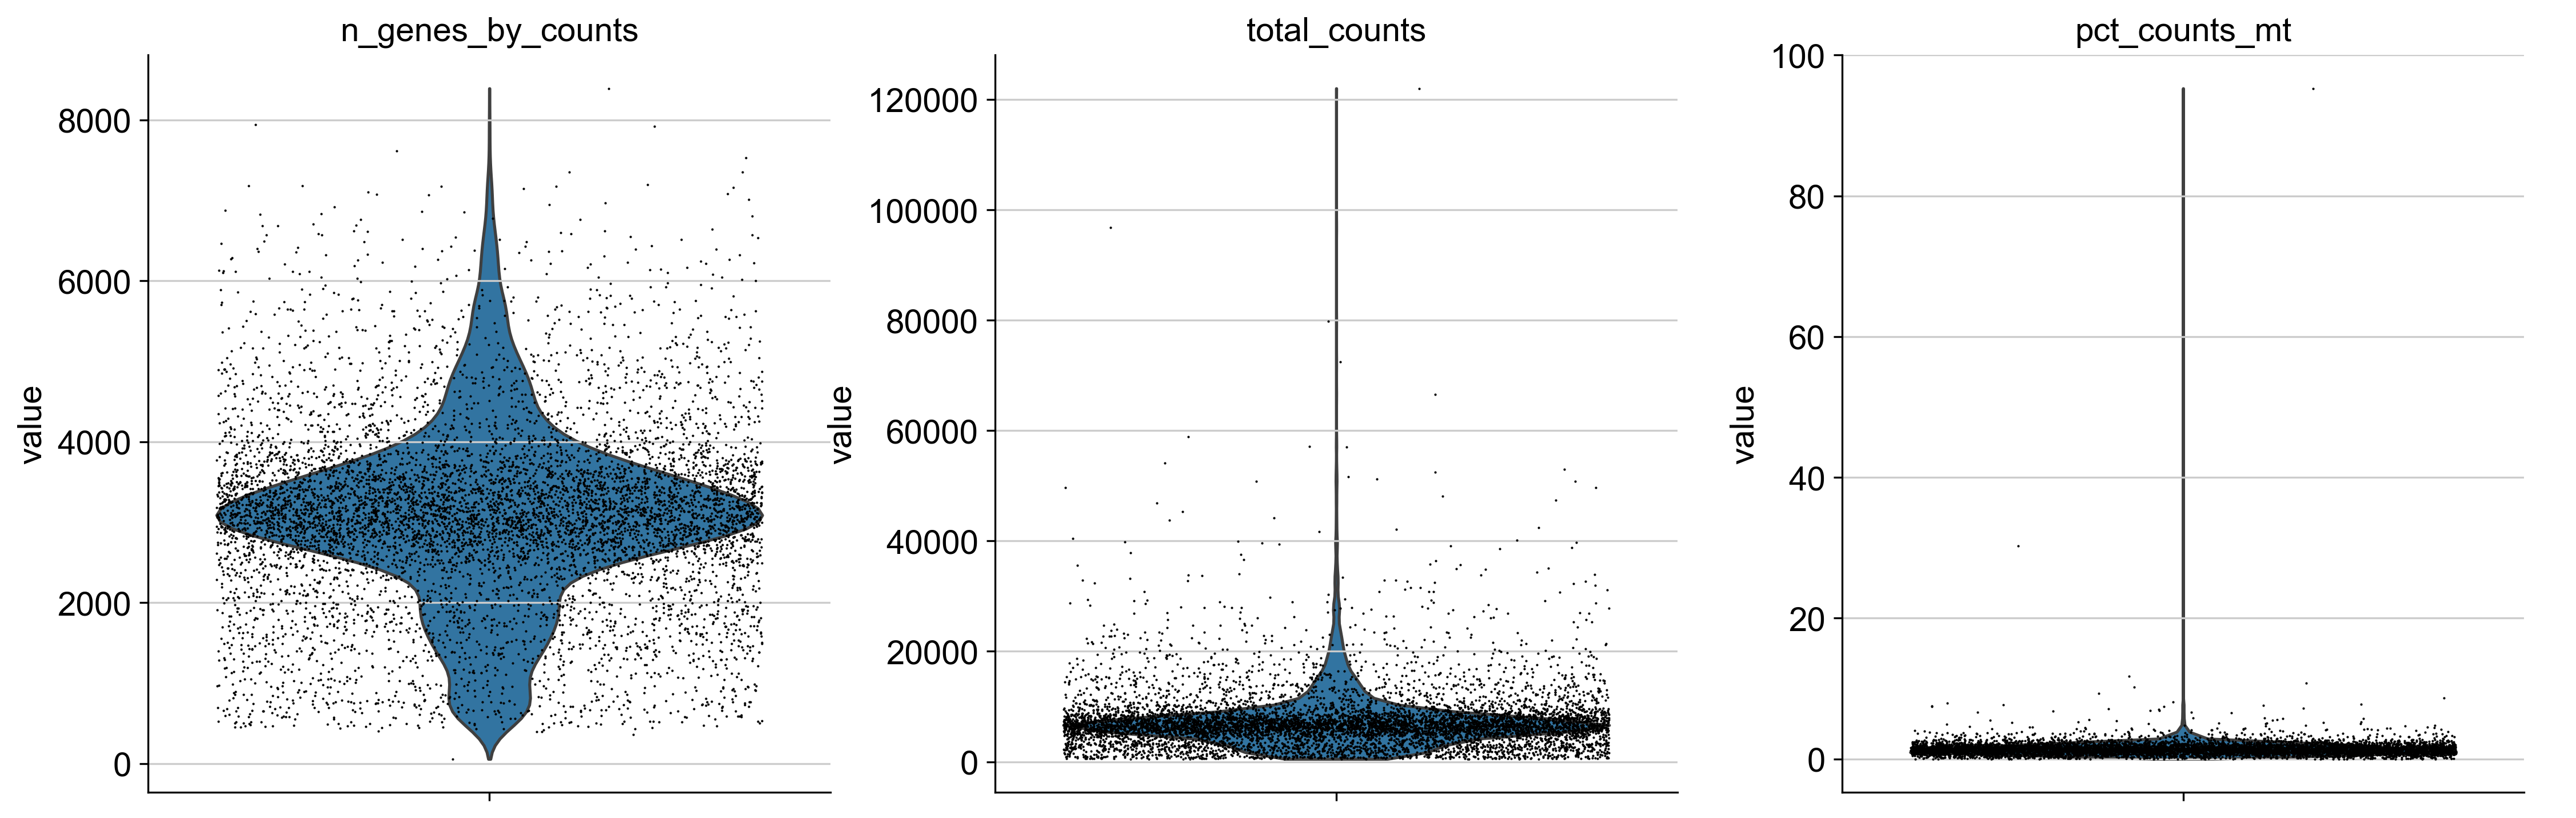

In [5]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4, 
    multi_panel=True,
)

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [7]:
# Doublet detection using scrublet
sc.external.pp.scrublet(adata)

Automatically set threshold at doublet score = 0.24
Detected doublet rate = 3.0%
Estimated detectable doublet fraction = 39.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.6%


In [8]:
# Remove doublets + other QC metrics
adata = adata[adata.obs['predicted_doublet'] == False]
sc.pp.filter_cells(adata, max_genes = 6000)
sc.pp.filter_cells(adata, max_counts = 35000)
adata = adata[adata.obs['pct_counts_mt'] < 5]

## Normalization, HVG, neighbors, PCA, UMAP

In [9]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalization (Shifted logarithm)
sc.pp.normalize_total(adata, target_sum=None)
sc.pp.log1p(adata) 
# scParadise use normalized data in adata.raw!!!
adata.raw = adata
# HVG
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
# PCA
sc.tl.pca(adata)
# Nearest neighbors analysis
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
# UMAP
sc.tl.umap(adata)
# Clusterization
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_0.5')

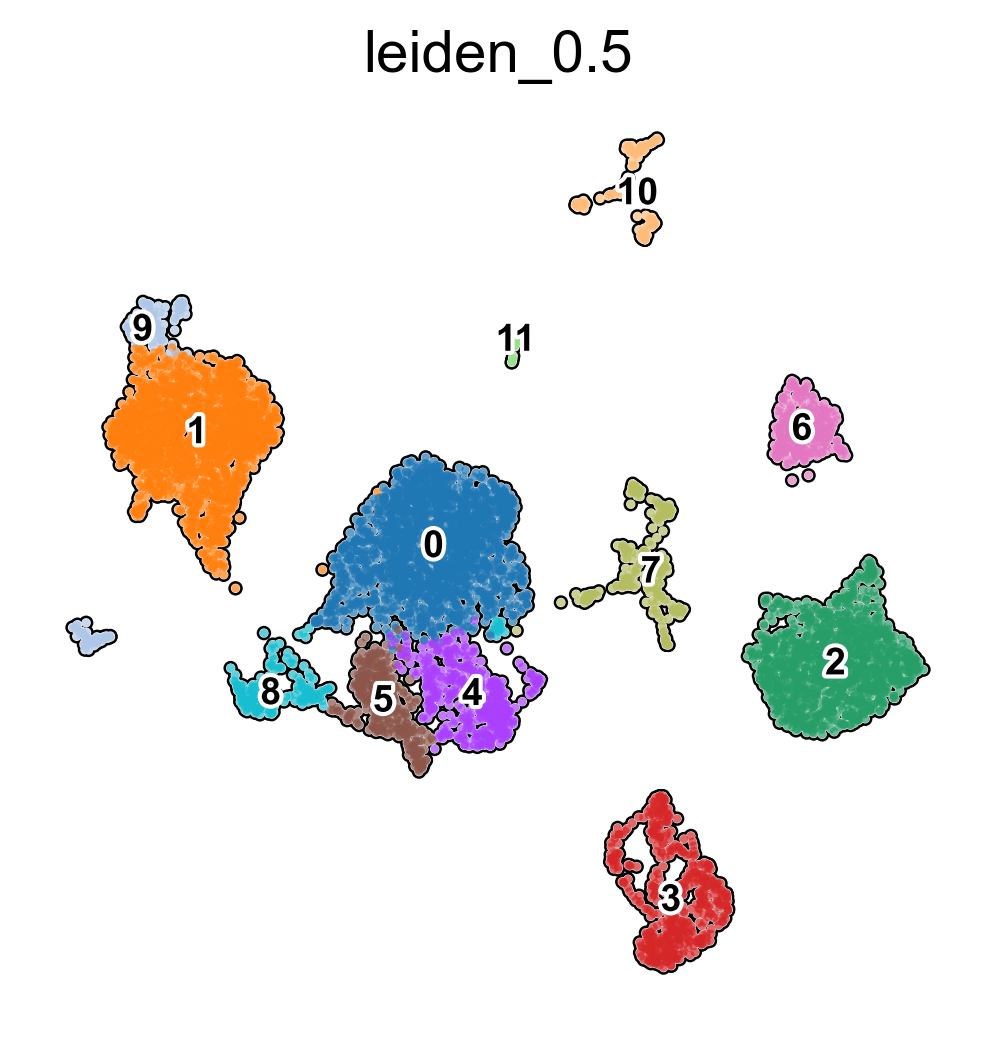

In [10]:
# Visualise predicted cell types levels and prediction probabilities
sc.pl.embedding(adata, 
                color = [
                    'leiden_0.5'
                ],
                basis = 'X_umap',
                frameon = False,
                add_outline = True,
                legend_loc = 'on data',
                legend_fontsize = 9,
                legend_fontoutline = 2,
                save='clusterization.png')

In [11]:
adata.write_h5ad('mouse_clusterization.h5ad')

## Observed ADT preprocessing

In [12]:
mu.prot.pp.clr(adata_adt)

In [13]:
adata_adt = adata_adt[adata.obs_names]
adata_adt.obsm['X_umap'] = adata.obsm['X_umap']

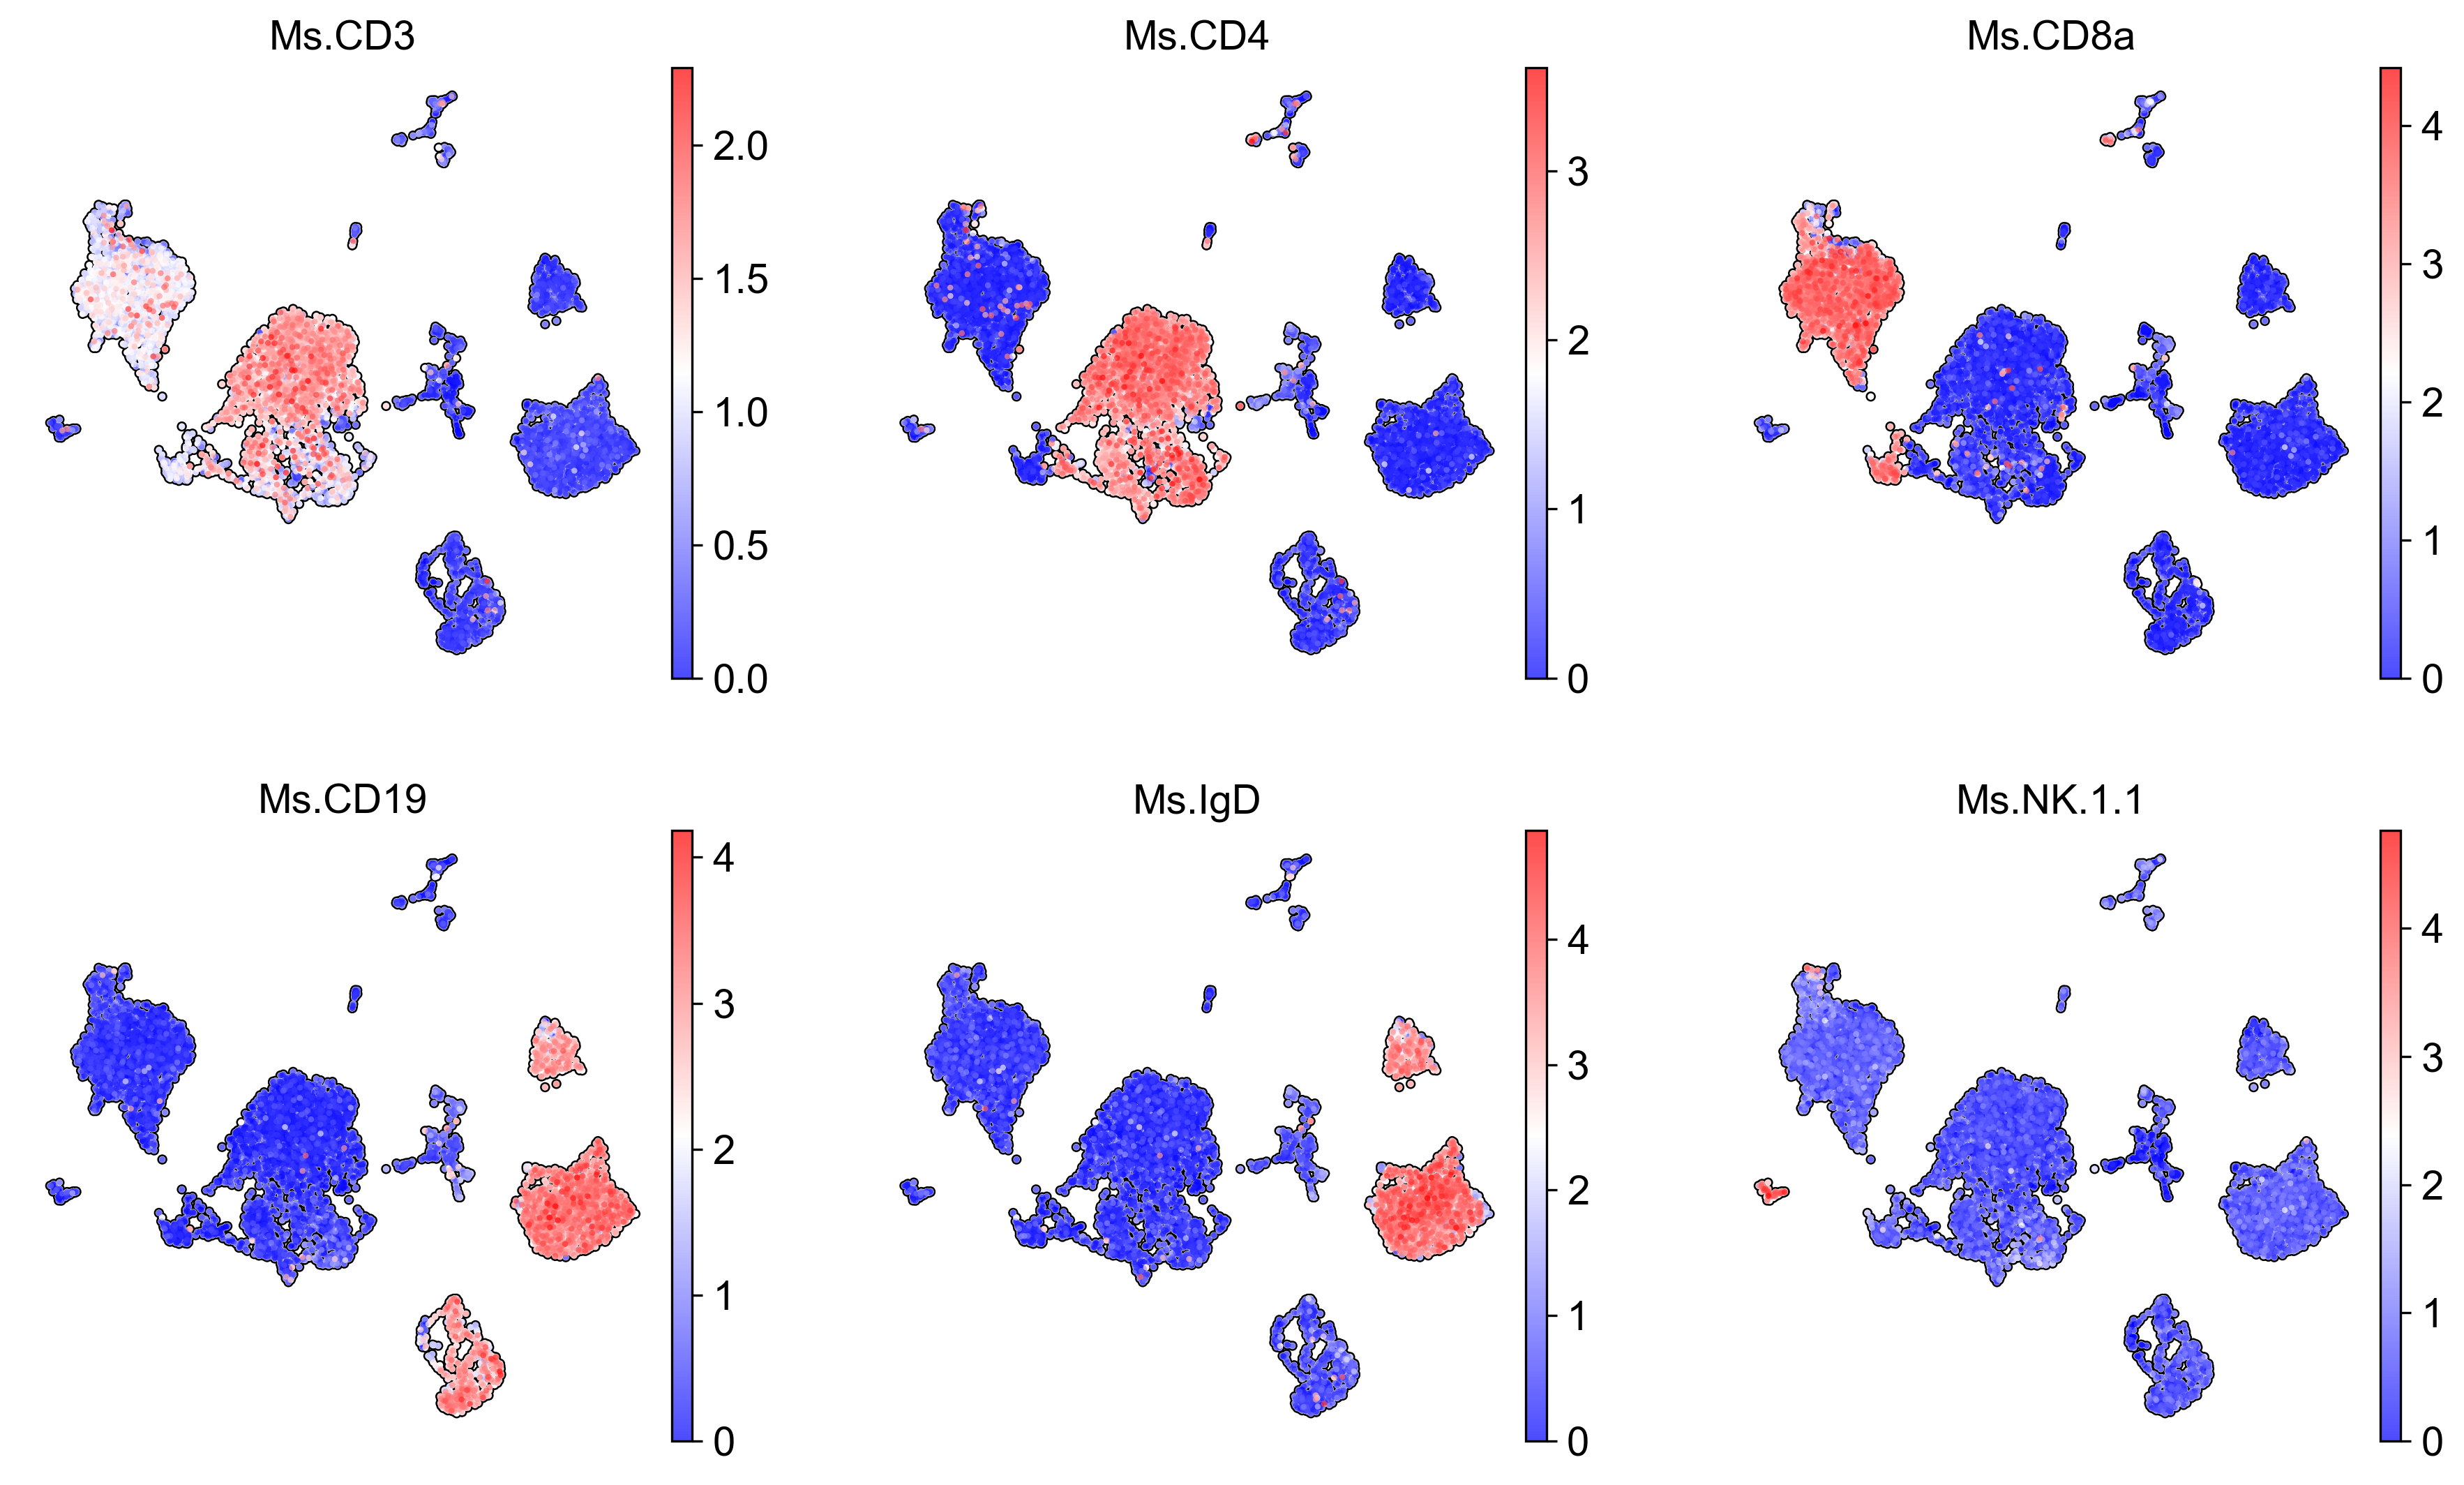

In [15]:
# Visualise naive T cells markers
sc.pl.embedding(adata_adt, 
                color = [
                    'Ms.CD3',
                    'Ms.CD4',
                    'Ms.CD8a',
                    'Ms.CD19',
                    'Ms.IgD',
                    'Ms.NK.1.1'
                ],
                basis = 'X_umap',
                frameon = False,
                add_outline = True,
                cmap = 'bwr',
                legend_loc = 'on data',
                legend_fontsize = 9,
                legend_fontoutline = 2,
                ncols = 3,
                save='_observed_proteins.png'
               )

## scParadise prediction (scEve)
To use the model trained on human cells, it is necessary to replace the names of mouse genes with their orthologs from the human genome. <br>
Orthologs - genes in different species that evolved from a common ancestor by speciation (Example: Acta2 in mouse, ACTA2 in human).

In [16]:
# Find orthologs of mouse genes in human genome
humanized_adata = translate(adata)

100%|██████████| 13167/13167 [00:18<00:00, 709.75it/s]


Found direct orthologs for 12219 genes.
Found multiple orthologs for 235 genes.
Found no orthologs for 442 genes.
Found no index in biomart for 271 genes.


100%|██████████| 235/235 [00:13<00:00, 17.83it/s]


In [17]:
# Check matrix type and add it to raw
humanized_adata.X = sparse.csc_matrix(humanized_adata.X)
humanized_adata.raw = humanized_adata

In [18]:
# Available models for cell type annotation
scparadise.sceve.available_models()

RMSE - Root Mean Squared Error
MSE - Mean Squared Error
MAE - Mean Absolute Error



Tissue/Model name                                        Description  \
0     Human_PBMC_3p  Peripheral blood mononuclear cells of healthy ...   
1     Human_PBMC_5p  Peripheral blood mononuclear cells of healthy ...   
2        Human_BMMC     Bone marrow mononuclear cell of healthy adults   

  Suspension   RMSE    MAE  Number of Proteins  
0      cells  0.305  0.226                 224  
1      cells  0.308  0.225                  54  
2      cells  0.706  0.454                 134

In [19]:
# Download model for modality prediction
scparadise.sceve.download_model(model_name = 'Human_PBMC_3p', 
                                save_path = '')

In [20]:
# Predict surface proteins using trained model
adata_adt_pred = scparadise.sceve.predict(humanized_adata, 
                                          path_model = 'Human_PBMC_3p_scEve/',
                                          return_mdata = False)

Successfully loaded list of genes used for training model

Successfully loaded list of proteins used for training model

Successfully loaded model



In [21]:
# Add UMAP from RNA data
adata_adt_pred.obsm['X_umap'] = adata.obsm['X_umap']

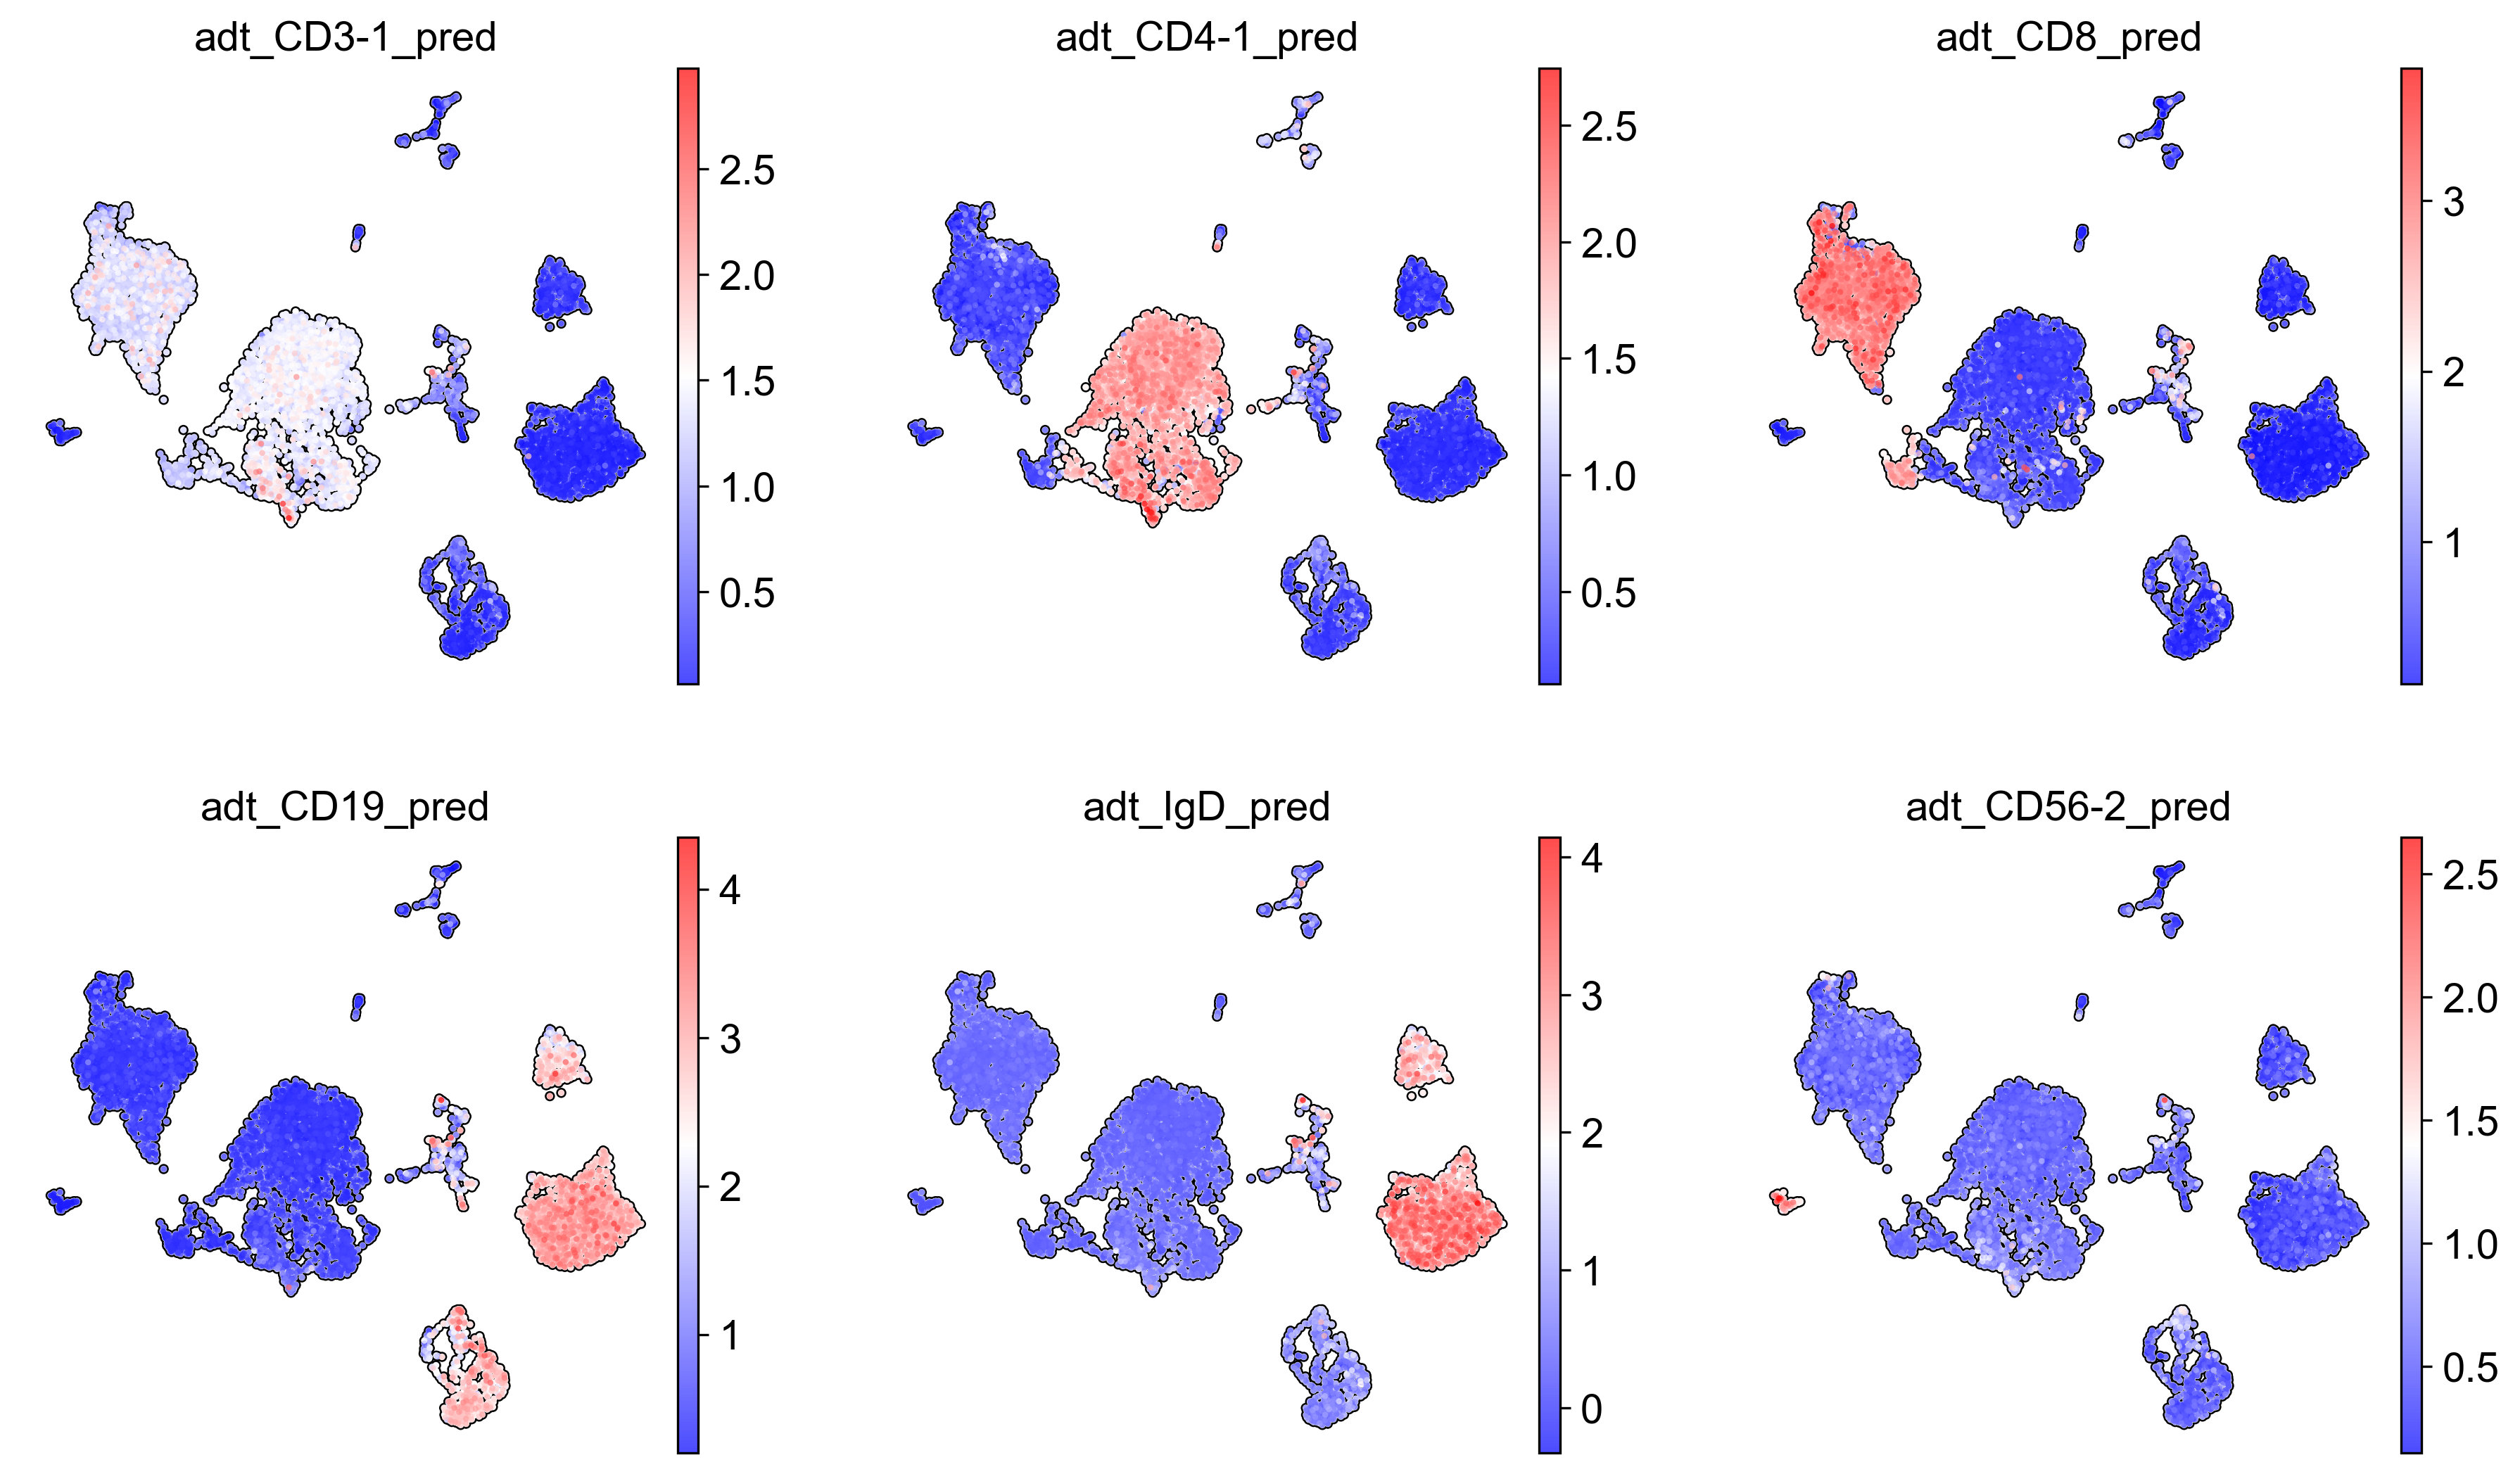

In [22]:
# Visualise predicted proteins
sc.pl.embedding(adata_adt_pred, 
                color = [
                    'adt_CD3-1_pred',
                    'adt_CD4-1_pred',
                    'adt_CD8_pred',
                    'adt_CD19_pred',
                    'adt_IgD_pred',
                    'adt_CD56-2_pred'
                ],
                basis = 'X_umap',
                frameon = False,
                add_outline = True,
                cmap = 'bwr',
                legend_loc = 'on data',
                legend_fontsize = 9,
                legend_fontoutline = 2,
                ncols = 3,
                save='_predicted_proteins.png'
               )

In [23]:
pip list

Package                       Version
----------------------------- ---------------
absl-py                       2.1.0
aiohttp                       3.9.3
aiosignal                     1.3.1
alabaster                     0.7.16
alembic                       1.13.2
anndata                       0.10.5.post1
anndata2ri                    1.3
annotated-types               0.6.0
annoy                         1.17.3
ansicon                       1.89.0
anyio                         4.2.0
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
array_api_compat              1.4.1
arrow                         1.3.0
astroid                       2.14.2
asttokens                     2.0.5
async-lru                     2.0.4
async-timeout                 4.0.3
atomicwrites                  1.4.0
attrs                         23.1.0
autopep8                      2.0.4
Babel                         2.11.0
backcall                      0.2.0
backoff                       2.2.1
bb